In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from lifelines.statistics import logrank_test

# Note

Trhoughout the notebook, the dataframe with GWAS results is called adp. It can thought represent other GWAS results. Just change the path at the beginning

Validated SNPS : SNPS whose p-value of association with ADP phenotype is significant (last 20-ile) compared to that of random features combinations

# Refine map

In [26]:
def add_block_to_df(df):
    # Groups SNPs in blocks
    # df must be in the bolt_lmm format
    df["block"] = -1
    
    validated_snps = [s[:-1] for s in open("%s/validated_snps/ADP.txt" % export_folder,"r").readlines()]
    
    p_cond = (df.SNP.isin(validated_snps)) & (df.SNP != ".")
    agg = AgglomerativeClustering(distance_threshold=int(1e6),linkage="single",n_clusters=None)
    global_offset = 0
    for ch in df.loc[p_cond].CHR.unique().tolist():
        s_cond = p_cond & (df.CHR == ch)
        if (s_cond.sum() > 1):
            labels = agg.fit_predict(np.reshape(df.loc[s_cond,"BP"].values,(-1,1)))
        else:
            labels = np.array([1])
        df.loc[s_cond,"block"] = labels + global_offset
        global_offset += np.max(labels) + 1
    return df

In [27]:
adp = pd.read_csv("%s/bolt_res_ADP_FIB" % export_folder, sep="\t")
adp = adp.dropna(axis=0,how="any")
adp.head(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_BOLT_LMM
0,rs568149713,1,15777,0,A,G,0.991900,0.037358,0.041778,0.034911,0.23,0.26
1,rs199745162,1,16949,0,A,C,0.986426,0.048444,-0.013448,0.027387,0.62,0.66
2,rs533090414,1,18849,0,C,G,0.022947,0.050817,-0.004801,0.021111,0.82,0.83


## Isolate blocks

In [28]:
adp["MBP"] = (adp["BP"] / 3e6).astype(int)*3
adp = adp.loc[adp.SNP != "."]

In [29]:
adp.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_BOLT_LMM,MBP
0,rs568149713,1,15777,0,A,G,0.991900,0.037358,0.041778,0.034911,0.23,0.26,0
1,rs199745162,1,16949,0,A,C,0.986426,0.048444,-0.013448,0.027387,0.62,0.66,0
2,rs533090414,1,18849,0,C,G,0.022947,0.050817,-0.004801,0.021111,0.82,0.83,0
3,rs2691277,1,52238,0,T,G,0.012584,0.050376,-0.021466,0.028152,0.45,0.45,0
4,rs552304420,1,54712,0,T,C,0.993450,0.021764,0.013500,0.038713,0.73,0.81,0


In [30]:
validated_snps = [s[:-1] for s in open("%s/validated_snps/ADP.txt" % export_folder,"r").readlines()]

In [31]:
adp = add_block_to_df(adp)

In [32]:
adp.loc[adp.block > 0].groupby("block").agg({"SNP":"nunique","CHR":"first","MBP":"median"})

,SNP,CHR,MBP
block,,,
1,78,1,198
2,1,1,156
4,1,4,6
5,2,5,120
6,295,6,24
7,23,7,78
8,79,8,105
9,80,8,144
10,2,9,111


## Build tables for Finemap (using MBP, not block)

In [4]:
def list_snps(table):
    return ",".join(table.SNP.tolist())
snp_lists = adp.loc[adp.P_BOLT_LMM < 5e-8].groupby(["CHR","MBP"]).apply(list_snps)

def make_z_df(df,snps):
    """
    Returns a table ready to be saved for Finemap (Z-table)
    """
    sub = df.loc[df.SNP.isin(snps)]
    sub = sub.rename(columns={"SNP":"rsid",
                              "CHR":"chromosome",
                              "BP":"position",
                              "ALLELE1":"allele1",
                              "ALLELE0":"allele2",
                              "A1FREQ":"maf",
                              "BETA":"beta",
                              "SE":"se"})
    sub = sub[["rsid","chromosome","position","allele1","allele2","maf","beta","se"]]
    sub.loc[sub.maf > 0.5,"maf"] = 1 - sub.loc[sub.maf > 0.5,"maf"]
    return sub
"""
rsid column contains the SNP identifiers. The identifier can be a rsID number or a combination of chromosome name and genomic position (e.g. XXX:yyy)

chromosome column contains the chromosome names. The chromosome names can be chosen freely with precomputed SNP correlations (e.g. 'X', '0X' or 'chrX')

position column contains the base pair positions

allele1 column contains the "first" allele of the SNPs. In SNPTEST this corresponds to 'allele_A', whereas BOLT-LMM uses 'ALLELE1'

allele2 column contains the "second" allele of the SNPs. In SNPTEST this corresponds to 'allele_B', whereas BOLT-LMM uses 'ALLELE0'

maf column contains the minor allele frequencies

beta column contains the estimated effect sizes as given by GWAS software

se
"""

'\nrsid column contains the SNP identifiers. The identifier can be a rsID number or a combination of chromosome name and genomic position (e.g. XXX:yyy)\n\nchromosome column contains the chromosome names. The chromosome names can be chosen freely with precomputed SNP correlations (e.g. \'X\', \'0X\' or \'chrX\')\n\nposition column contains the base pair positions\n\nallele1 column contains the "first" allele of the SNPs. In SNPTEST this corresponds to \'allele_A\', whereas BOLT-LMM uses \'ALLELE1\'\n\nallele2 column contains the "second" allele of the SNPs. In SNPTEST this corresponds to \'allele_B\', whereas BOLT-LMM uses \'ALLELE0\'\n\nmaf column contains the minor allele frequencies\n\nbeta column contains the estimated effect sizes as given by GWAS software\n\nse\n'

## Run finemap

In [5]:
causal_snps = []

z = []
ld = []
snp_files = []
config = []
cred = []

for i, block in enumerate(snp_lists):
    snps = block.split(",")
    n_snps = len(snps)
    if n_snps > 1:
        # Save SNP list to a file
        snp_list_file = "%s/fine_mapping/ADP/%s.snps" % (export_folder,snps[0])
        with open(snp_list_file,"w") as f:
            for snp in snps:
                f.write("%s\n" % snp)
                
        # Z File
        z_table = make_z_df(adp, snps)
        z_file = "%s/fine_mapping/ADP/%s.z" % (export_folder,snps[0])
        z_table.to_csv(z_file, sep=" ",index=False)
        
        # LD File
        chromosome = snp_lists.index[i][0]
        command = "/home/hv270/plink "
        command += "--bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d " % chromosome
        #command += "--ld-snp-list %s " % snp_list_file
        command += "--r square 'spaces' "
        command += "--extract %s " % snp_list_file
        command += "--out %s/fine_mapping/ADP/%s" % (export_folder,snps[0])
        
        p = subprocess.Popen(command,shell=True)
        p.wait()
        
        LD_file = "%s/fine_mapping/ADP/%s.ld" % (export_folder,snps[0])
        
        master_table = pd.DataFrame.from_dict({"z":[z_file],"ld":[LD_file],
                                       "snp":["%s/fine_mapping/ADP/%s.snp" % (export_folder,snps[0])],
                                        "config":["%s/fine_mapping/ADP/%s.config" % (export_folder,snps[0])],
                                       "cred":["%s/fine_mapping/ADP/%s.cred" % (export_folder,snps[0])]},
                                              orient="columns")
        master_table["n_samples"] = 27000
        master_table.head()
        
        master_file = "%s/fine_mapping/ADP/master_table.csv" % export_folder
        master_table.to_csv(master_file,sep=";",index=False)
        
        command = "/home/hv270/finemap_v1.4_x86_64/finemap_v1.4_x86_64 --sss --in-files %s --n-causal-snps %d --n-threads 8" % (master_file, min(len(snps),30))
        p = subprocess.Popen(command,shell=True)
        p.wait()
        
        conf_df = pd.read_csv("%s/fine_mapping/ADP/%s.config" % (export_folder,snps[0]),sep=" ")
        best_conf = str(conf_df["config"].iloc[0])
        causal_snps += best_conf.split(",")
        print("Picked %d causal snps out of %d" % (len(best_conf.split(",")), len(snps)))
    else:
        causal_snps.append(snps[0])

Picked 3 causal snps out of 23
Picked 2 causal snps out of 4
Picked 2 causal snps out of 15
Picked 13 causal snps out of 93
Picked 5 causal snps out of 52
Picked 1 causal snps out of 7
Picked 1 causal snps out of 4
Picked 30 causal snps out of 592
Picked 2 causal snps out of 93
Picked 29 causal snps out of 304
Picked 4 causal snps out of 15
Picked 1 causal snps out of 4
Picked 5 causal snps out of 55
Picked 1 causal snps out of 90
Picked 18 causal snps out of 120
Picked 1 causal snps out of 116
Picked 2 causal snps out of 3
Picked 13 causal snps out of 205
Picked 1 causal snps out of 7
Picked 2 causal snps out of 93
Picked 1 causal snps out of 25
Picked 7 causal snps out of 52
Picked 6 causal snps out of 42
Picked 5 causal snps out of 40
Picked 1 causal snps out of 8
Picked 5 causal snps out of 111
Picked 2 causal snps out of 17
Picked 1 causal snps out of 3
Picked 15 causal snps out of 394


# Run stepwise conditional analysis

## Extract genotypes

In [67]:
SNP_list = adp.loc[(adp.block > -1) & (adp.SNP != ".")].SNP.tolist()
print(len(SNP_list))
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

633


In [68]:
SNP_list_file = "%s/conditional_analysis/significant_snps_ADP_validated.txt" % export_folder
with open(SNP_list_file,"w") as file:
    for s in SNP_list:
        file.write("%s\n" % s)

## Plink Command

In [69]:
for ch in adp.loc[(adp.block > -1) & (adp.SNP != ".")].CHR.unique().tolist():
    command = "/home/hv270/plink"
    command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % ch
    command += " --extract %s" % SNP_list_file
    command += " --recode A-transpose --out %s/conditional_analysis/genotypes_chr_%d" % (export_folder, ch) 
    p = subprocess.Popen(command,shell=True)
    p.wait()
    print("Done ch %d" % ch)

Done ch 1
Done ch 4
Done ch 5
Done ch 6
Done ch 7
Done ch 8
Done ch 9
Done ch 15
Done ch 16
Done ch 18
Done ch 19
Done ch 20


## Load tables

### Genotypes

In [33]:
dfs = []
for ch in adp.loc[(adp.block > -1) & (adp.SNP != ".")].CHR.unique().tolist():
    df = pd.read_csv("%s/conditional_analysis/genotypes_chr_%d.traw" % (export_folder, ch),sep="\t")
    dfs.append(df)
    print(df.shape)

(91, 43065)
(1, 43065)
(2, 43065)
(295, 43065)
(23, 43065)
(159, 43065)
(2, 43065)
(1, 43065)
(20, 43065)
(29, 43065)
(6, 43065)
(4, 43065)


In [34]:
gen = pd.concat(dfs,axis=0)

### Phenotypes and covariates

In [35]:
pheno = pd.read_csv("%s/phenotypes.csv" % export_folder, sep="\t")

In [36]:
cov = pd.read_csv("%s/covariates.csv" % export_folder, sep="\t")

In [37]:
pheno.head()

,FID,IID,PAR4_FIB,PAR1_FIB,TRAP_FIB,ADP_FIB,CRP_FIB,FIB
0,110018327792,110018327792,-1.590170,-1.628887,-1.467105,-1.480886,-1.529809,-1.544555
1,110018483652,110018483652,0.341331,0.251202,0.101277,0.246509,0.307578,0.262783
2,110001259381,110001259381,0.513022,0.584504,0.426149,0.608930,0.616931,0.542091
3,110004412832,110004412832,0.638058,0.587401,0.571037,0.720729,0.480298,0.615049
4,110003866786,110003866786,0.181371,0.094056,0.260232,0.137544,0.205264,0.186840


In [38]:
cov.head()

,FID,IID,cohort_covar,sexPulse,age_covar,PLT_wb,MPV_wb,PDW_wb,PCT_wb,PC1,PC2,PC3,PC4,PC5
0,110018327792,110018327792,2,2,-0.631139,-0.458333,-0.750000,-0.678571,-1.000000,-0.003431,-0.004429,0.005799,0.005465,-0.004632
1,110018483652,110018483652,5,2,0.693835,-0.597222,1.000000,1.142857,-0.285714,0.006413,0.005157,0.008395,0.002881,0.008806
2,110001259381,110001259381,0,2,-0.714734,-0.861111,0.833333,0.857143,-0.714286,0.001189,-0.001928,0.007722,-0.014941,0.004064
3,110004412832,110004412832,0,2,0.535005,-0.736111,0.750000,0.785714,-0.571429,-0.009439,-0.007902,0.003113,-0.002499,-0.000451
4,110003866786,110003866786,3,2,0.815047,-0.166667,-0.416667,-0.357143,-0.285714,-0.001606,-0.000988,-0.006682,-0.002042,-0.003743


In [39]:
covar_cols = ["cohort_covar","sexPulse","age_covar","PLT_wb","MPV_wb","PDW_wb","PCT_wb","PC1","PC2","PC3","PC4","PC5"]
merged = pd.merge(cov.set_index("IID")[covar_cols],pheno.set_index("IID")[["ADP_FIB"]],left_index=True,right_index=True,how="inner")

In [40]:
merged.shape

(29498, 13)

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
lm = LinearRegression().fit(merged[covar_cols],merged["ADP_FIB"])

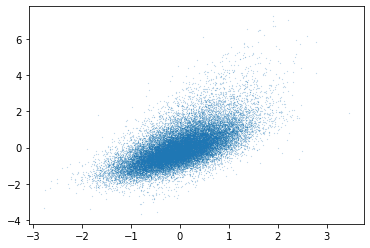

In [43]:
y_hat = np.reshape(lm.predict(merged[covar_cols]),(-1))
y_true = merged["ADP_FIB"]
plt.scatter(y_hat,y_true,s=.01)

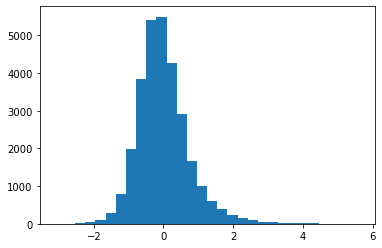

In [44]:
merged["adjusted_ADP"] = y_true - y_hat
plt.hist(merged.adjusted_ADP,bins=30)
pass

### Merge both

In [45]:
gen.head()

,CHR,SNP,(C)M,POS,COUNTED,ALT,110000305926_110000305926,110000305952_110000305952,110000315493_110000315493,110000315494_110000315494,...,119999995898_119999995898,119999995908_119999995908,119999995910_119999995910,119999995920_119999995920,119999995922_119999995922,119999995932_119999995932,119999995934_119999995934,119999995944_119999995944,119999995956_119999995956,119999995958_119999995958
0,1,rs4838959,0,113085721,A,C,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0
1,1,rs10776757,0,113121673,G,C,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0
2,1,rs663533,0,113128804,G,C,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0
3,1,rs4839254,0,113140926,C,T,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0
4,1,rs9429486,0,113157372,T,C,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0


In [46]:
ID_cols = gen.columns[6:]

In [47]:
_ = gen.set_index("SNP")[ID_cols].T.reset_index().rename(columns={"index":"ID"})
_["ID"] = _["ID"].apply(lambda x: int(x.split("_")[0]))
gen = _.set_index("ID")

In [48]:
gen.head()

SNP,rs4838959,rs10776757,rs663533,rs4839254,rs9429486,rs55675817,rs12046208,rs72699100,rs12042407,rs4604691,...,rs8109288,rs79301674,rs8104011,rs2228367,rs73517714,rs57843631,rs73076965,rs7271240,rs10485824,rs56078965
ID,,,,,,,,,,,,,,,,,,,,,
110000305926,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110000305952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
110000315493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110000315494,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110000315495,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [49]:
ft = pd.merge(gen, merged,left_index=True,right_index=True,how="inner")

# Run the selection

## Extract SNPS list from UKBB

In [4]:
EUR_path = "%s/genetic_score/EUR" % export_folder
SNP_list_file = "%s/conditional_analysis/significant_snps_ADP_validated.txt" % export_folder
n_splits = 4
for chrom in range(1,23):
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --keep %s" % EUR_path
    command += " --extract %s" % SNP_list_file
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --write-snplist"
    command += " --threads %d" % n_splits
    command += " --out %s/genetic_score/ukbb_snps_%d" % (export_folder,chrom)

    f_name = "/home/hv270/interval_slurm_calls/call_list_chr%d.sh" % chrom
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J list%d\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=3:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    log_file = "/home/hv270/slurm_log/%s_list_UKBB_snps_chr_%d.out" % ("GS",chrom)
    f.write("#SBATCH --output=%s\n" % log_file)
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % chrom)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22


In [62]:
IDs_list = []
for ch in range(1,23):
    try:
        IDs_chrom = pd.read_csv("%s/genetic_score/ukbb_snps_%d-temporary.pvar" % (export_folder, ch),sep="\t")["ID"].tolist() 
        IDs_list = IDs_list + IDs_chrom
    except Exception as e:
        print(e)
        pass

[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ukbb_snps_10-temporary.pvar' does not exist: b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ukbb_snps_10-temporary.pvar'
[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ukbb_snps_11-temporary.pvar' does not exist: b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ukbb_snps_11-temporary.pvar'
[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ukbb_snps_13-temporary.pvar' does not exist: b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ukbb_snps_13-temporary.pvar'
[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ukbb

In [15]:
len(IDs_list)

67062755

In [54]:
IDs_list = [c for c in IDs_list if "rs" == str(c)[:2]]
print(len(IDs_list))

63325626


In [55]:
from scipy.stats import pearsonr, ttest_ind, f, levene
def get_p_value(X,new_col,Y):
    c = (X.isnull().sum(axis=1) == 0) & (new_col.isnull().sum(axis=1) == 0)
    X_ = X.loc[c]
    Y_ = Y.loc[c]
    new_col_ = new_col.loc[c]
    X_2 = pd.concat((X_,new_col_),axis=1)
    
    lm1 = LinearRegression().fit(X_,Y_)
    fit_1 = lm1.predict(X_)
    lm2 = LinearRegression().fit(X_2,Y_)
    fit_2 = lm2.predict(X_2)
    
    #p_val = f_test(fit_1,fit_2)[1]
    p_val = levene(fit_1,fit_2,center="mean")[1]

    return p_val

def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    F = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-f.cdf(F, dfn, dfd) #find p-value of F test statistic 
    print(dfn)
    return f, p

def get_causal_columns(X,Y):
    included = [0]
    excluded = [k for k in range(1,X.shape[1])]
    P_th = 8.31*1e-9
    LD = []
    c = (X.isnull().sum(axis=1) == 0)
    for k in excluded:
        if pearsonr(X.loc[c].iloc[:,k],
                    X.loc[c].iloc[:,0])[0]**2 > 0.9:
            LD.append(k)
    excluded = [k for k in excluded if k not in LD]
    print("Removed %d SNPs in high LD (remains %d)" % (len(LD),len(excluded)))
    while len(excluded) > 0:
        # INCLUDE
        #print(included)
        ps = []
        for i in excluded:
            ps.append(get_p_value(X.iloc[:,included],X.iloc[:,[i]],Y))
        if min(ps) > P_th:
            return included
        new_c = excluded[np.argmin(ps)]
        included = included + [new_c]
        excluded = [e for e in excluded if e != new_c]

        if len(included) == 1: continue

        while len(included) >= 2:
            ps = []
            for i in included:
                inc_ = [k for k in included if k != i]
                ps.append(get_p_value(X.iloc[:,inc_],X.iloc[:,[i]],Y))
            if max(ps) < P_th:
                break
            else:
                old_c = included[np.argmax(ps)]
                excluded += [old_c]
                included = [k for k in included if k != old_c]
                
    return [0]
    

In [56]:
adp["MAF"] = adp["A1FREQ"]
adp.loc[adp.MAF > 0.5, "MAF"] = 1 - adp.loc[adp.MAF > 0.5, "MAF"]

In [ ]:
snp_in_ukbb = adp.SNP.isin(IDs_list)

In [61]:
blocks = adp.loc[adp.block > -1].block.unique().tolist()
causal_snps = []

for b in blocks:
    sub_adp = adp.loc[(adp.block == b) & (adp.MAF > 5e-4) & snp_in_ukbb]
    snps = sub_adp.sort_values("P_BOLT_LMM",ascending=True).SNP.tolist()
    if len(snps) == 0: continue
    X = ft[snps]
    Y = ft["adjusted_ADP"]
    causal = get_causal_columns(X,Y)
    print(sub_adp.CHR.iloc[0],[snps[k] for k in causal])
    causal_snps += [snps[k] for k in causal]

Removed 11 samples in high LD (remains 0)
1 ['rs10776757']
Removed 0 samples in high LD (remains 0)
1 ['rs72698679']
Removed 4 samples in high LD (remains 71)
1 ['rs1434282']
Removed 0 samples in high LD (remains 0)
4 ['rs11731274']
Removed 0 samples in high LD (remains 1)
5 ['rs10455038']
Removed 18 samples in high LD (remains 258)
6 ['rs57318254', 'rs212936']
Removed 18 samples in high LD (remains 4)
7 ['rs1194196', 'rs819437']
Removed 2 samples in high LD (remains 71)
8 ['rs6993770']
Removed 0 samples in high LD (remains 1)
9 ['rs117149770']
Removed 0 samples in high LD (remains 0)
15 ['rs59001897']


In [89]:
blocks = adp.loc[adp.block > -1].block.unique().tolist()
causal_snps = []
for b in blocks:
    snps = adp.loc[(adp.block == b) & (adp.MAF > 5e-4) & adp.SNP.isin(IDs_list)].sort_values("P_BOLT_LMM",ascending=True).SNP.tolist()
    X = ft[snps]
    Y = ft["adjusted_ADP"]
    causal = get_causal_columns(X,Y)
    print([snps[k] for k in causal])
    causal_snps += [snps[k] for k in causal]

Removed 11 samples in high LD (remains 0)
['rs10776757']
Removed 0 samples in high LD (remains 0)
['rs72698679']
Removed 4 samples in high LD (remains 73)
['rs1434282']
Removed 0 samples in high LD (remains 0)
['rs11731274']
Removed 0 samples in high LD (remains 1)
['rs10455038']
Removed 19 samples in high LD (remains 275)
['rs57318254', 'rs212936']
Removed 18 samples in high LD (remains 4)
['rs1194196', 'rs819437']
Removed 2 samples in high LD (remains 76)
['rs6993770']
Removed 8 samples in high LD (remains 71)
['rs11785060']
Removed 0 samples in high LD (remains 1)
['rs117149770']
Removed 0 samples in high LD (remains 0)
['rs59001897']
Removed 17 samples in high LD (remains 2)
['rs114932910']
Removed 25 samples in high LD (remains 3)
['rs11315757']
Removed 5 samples in high LD (remains 0)
['rs8104011']
Removed 2 samples in high LD (remains 1)
['rs10485824']


# Extract EU individuals

In [90]:
european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"FID"})
european_individuals["IID"] = european_individuals["FID"]
EUR_path = "%s/genetic_score/EUR" % export_folder
european_individuals[["IID","FID"]].to_csv(EUR_path,index=False)

In [91]:
european_individuals.head()

,FID,IID
0,3988147,3988147
1,5152243,5152243
2,2770265,2770265
3,3790399,3790399
4,4681935,4681935


# Compute score

In [ ]:
"""
adp["causal"] = adp.SNP.isin(causal_snps)
causal_adp_snps = adp.loc[adp.causal].SNP.tolist()
with open(causal_snps_path,"w") as snp_file:
    for snp in causal_adp_snps:
        snp_file.write("%s\n" % snp)
"""
european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"ID_1"})
european_individuals["ID_2"] = european_individuals["ID_1"]
EUR_path = "%s/genetic_score/EUR" % export_folder
european_individuals[["ID_1","ID_2"]].to_csv(EUR_path,index=False, sep="\t", header=False)

## Validated SNPS

Validated SNPS : those whose p-value of association is significantly better than with random phenotypes

In [179]:
n_splits = 12
causal_snps_path = "%s/genetic_score/causal_snps_validated" % (export_folder)
left_to_do_chroms = []
for chrom in range(1,23)[::-1]:
    
    log_file = "/home/hv270/slurm_log/%s_ADP_val_%d.out" % ("GS",chrom)
    with open(log_file,"r") as f:
        lines = f.readlines()
        print(chrom, lines[-5])
        if "DUE TO TIME LIMIT" in lines[-2]:
            left_to_do_chroms.append(chrom)
print(left_to_do_chroms)

22 /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr22-temporary.pvar.

21 /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr21-temporary.pvar.

20 --score: 1 variant processed.

19 --score: 1 variant processed.

18 /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr18-temporary.pvar.

17 /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr17-temporary.pvar.

16 /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr16-temporary.pvar.

15 --score: 1 variant processed.

14 /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr

In [13]:
for chrom in left_to_do_chroms:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%d_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%d_v3_s487378.sample" % chrom
    #command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1"
    command += " --extract %s" % causal_snps_path
    #command += " --keep %s" % EUR_path
    command += " --score %s/bolt_res_ADP_FIB 1 5 9 header" % (export_folder)
    #command += " --q-score-range %s %s/bolt_res_ADP_FIB 1 12" % (range_file_path, export_folder)
    #useless if we keep only causal SNPs with good p values
    command += " --out %s/genetic_score/ADP_causal_score_validated_chr%d" % (export_folder,chrom)
    command += " --threads %d" % n_splits

    f_name = "/home/hv270/interval_slurm_calls/call_gs_chr%d.sh" % chrom
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%d\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=8:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    log_file = "/home/hv270/slurm_log/%s_ADP_val_%d.out" % ("GS",chrom)
    f.write("#SBATCH --output=%s\n" % log_file)
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % chrom)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 8
Submitting 4


## All causal SNPs

In [171]:
left_to_do_chroms = []
for chrom in range(1,23)[::-1]:
    
    log_file = "/home/hv270/slurm_log/%s_ADP_%d.out" % ("GS",chrom)
    with open(log_file,"r") as f:
        lines = f.readlines()
        if "DUE TO TIME LIMIT" in lines[-2]:
            left_to_do_chroms.append(chrom)
print(left_to_do_chroms)

[6]


In [172]:
n_splits = 12
causal_snps_path = "%s/genetic_score/causal_snps" % (export_folder)

for chrom in left_to_do_chroms:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%d_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%d_v3_s487378.sample" % chrom
    #command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1"
    command += " --extract %s" % causal_snps_path
    #command += " --keep %s" % EUR_path
    command += " --score %s/bolt_res_ADP_FIB 1 5 9 header" % (export_folder)
    #command += " --q-score-range %s %s/bolt_res_ADP_FIB 1 12" % (range_file_path, export_folder)
    #useless if we keep only causal SNPs with good p values
    command += " --out %s/genetic_score/ADP_causal_score_chr%d" % (export_folder,chrom)
    command += " --threads %d" % n_splits

    f_name = "/home/hv270/interval_slurm_calls/call_gs_chr%d.sh" % chrom
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%d\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=6:30:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_ADP_%d.out\n" % ("GS",chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % chrom)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 6


# Compute score of Sysmex features

In [152]:
sys_gwas = pd.read_excel("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/GWAS_Sysmex_traits_hits.xlsx")

In [153]:
sys_gwas = sys_gwas.rename(columns={"Associated Blood Index":"pheno",
                                    "rsID (where available)":"rsID",
                                    "Chr (GRCh37)":"CHR",
                                    "BP (GRCh37)":"BP",
                                    "REF (GRC37)":"REF",
                                    "ALT (GRC37)":"ALT",
                                    "(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)":"BETA"})
sys_phenos = ["PLT#","MPV","PCT","PDW"]
sys_gwas = sys_gwas.loc[sys_gwas["pheno"].isin(sys_phenos)]

In [154]:
sys_gwas[["pheno","rsID","CHR","BP","REF","ALT","BETA"]].head()

,pheno,rsID,CHR,BP,REF,ALT,BETA
8,PLT#,rs34646035,1,2166607,G,GT,-0.025125
9,PCT,rs34646035,1,2166607,G,GT,-0.022806
10,PDW,rs141190925,1,2234040,CAGG,C,-0.031649
14,PCT,rs113565775,1,2978755,A,AG,0.029835
16,PCT,rs1569419,1,2996602,T,C,0.041643


In [ ]:
for pheno in sys_phenos:
    # Checked only on one sample, that REF was the column to use
    # It corresponds to the same side (between ref and alt) 
    # as the one used to compute the score of our phenotypes based on interval GWAS
    betas_path = "%s/Genetic_score_Sysmex_traits/%s.csv" % (export_folder,pheno)
    sys_gwas.loc[sys_gwas.pheno == pheno,["rsID","REF","BETA"]]\
        .to_csv(betas_path,
                sep="\t",index=False,header=False)
    
    causal_snps = sys_gwas.loc[sys_gwas.pheno == pheno].rsID.tolist()
    causal_snps_path = "%s/Genetic_score_Sysmex_traits/causal_snps_%s" % (export_folder,pheno)
    with open(causal_snps_path,"w") as snp_file:
        for snp in causal_snps:
            snp_file.write("%s\n" % snp)
    
    n_splits = 8

    for chrom in sys_gwas.loc[sys_gwas.pheno == pheno].CHR.unique().tolist():
        command = "/home/hv270/Plink2/plink2"
        command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
        command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
        #command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1"
        command += " --extract %s" % causal_snps_path
        #command += " --keep %s" % EUR_path
        command += " --score %s" % betas_path
        #command += " --q-score-range %s %s/bolt_res_ADP_FIB 1 12" % (range_file_path, export_folder)
        #useless if we keep only causal SNPs with good p values
        command += " --out %s/Genetic_score_Sysmex_traits/%s_causal_score_chr%s" % (export_folder,pheno,chrom)
        command += " --threads %d" % n_splits

        f_name = "/home/hv270/interval_slurm_calls/call_gs_chr%s.sh" % chrom
        f = open(f_name,"w+")
        f.write("#!/bin/sh\n")

        f.write("#SBATCH -J chr%s\n" % (chrom))
        f.write("#SBATCH -A ASTLE-SL2-CPU\n")
        f.write("#SBATCH -N 1\n")
        f.write("#SBATCH -n %d\n" % n_splits)
        #f.write("#SBATCH -c %d\n" % n_splits)
        f.write("#SBATCH --time=3:30:00\n")
        f.write("#SBATCH -p skylake\n")
        f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("GS",pheno,chrom))
        f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

        f.write(". /etc/profile.d/modules.sh\n")
        f.write("module purge\n")
        f.write("module load rhel7/default-peta4\n")
        f.write(command)
        f.close()

        print("Submitting %s" % chrom)
        p = subprocess.Popen("sbatch %s" % f_name,shell=True)
        p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19


# Read table

In [24]:
STROKE_FIELD = "42006-0.0"
BIRTH_FIELD = "34-0.0"
SEX_FIELD = "31-0.0" # 0 female, 1 male
MI_FIELD = "42000-0.0" 
AGE_DVT = "4012-0.0" # Deep venous thrombosis, blot clot in the leg
PE_FIELD  = "4022-0.0" # pulmonary embolism, age
KINSHIP = '22021-0.0'
DEATH_FIELD = '40007-0.0'
BP_FIELD = '2966-0.0' # Age high blood pressure diagnosed
PLT = '30080-0.0'
PCT = '30090-0.0'
MPV = '30100-0.0'
PDW = '30110-0.0'

TOBACCO_FIELD = "22506-0.0"
ID_FIELD = "eid"


In [25]:
ukbb_path = "/home/hv270/rds/rds-who1000-cbrc/data/UKB_13745/flat_data/ukb44092.csv"

for chunk in pd.read_csv(ukbb_path,sep=",",chunksize=int(1e2),low_memory=False):
    ukbb_ = chunk
    break
ICD10_cols = [c for c in ukbb_ if "41270" in c]
death_cols = [c for c in ukbb_ if "40002" in c]

cols = [ID_FIELD,BIRTH_FIELD,SEX_FIELD,STROKE_FIELD,
        MI_FIELD, PE_FIELD, AGE_DVT,
        DEATH_FIELD,
        BP_FIELD,
        MPV, PCT, PDW, PLT,
        TOBACCO_FIELD, KINSHIP]
cols = cols + ICD10_cols #+ death_cols

ukbb_ = pd.read_csv(ukbb_path,sep=",",usecols=cols, low_memory=True)

/home/hv270/platelets/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20817,20818,20819,20820,20821,20822,20823,20824,20825,20826,20827,20828,20829,20830,20831,20832,20833,20834,20835,20836,20837,20838,20839,20840,20841,20842,20843,20844,20845,20846,20847,20848,20849,20850,20851,20852,20853,20854,20855,20856,20857,20858,20859,20860,20861,20862,20863,20864,20865,20866,20867,20868,20869,20870,20871,20872,20873,20874,20875,20876,20877,20878,20879,20880,20881,20882,20883,20884,20885,20886,20887,20888,20889,20890,20891,20892,20893,20894,20895,20896,20897,20898,20899,20900,20901,20902,20903,20904,20905,20906,20907,20908,20909,20910,20911,20912,20913,20914,20915,20916,20917,20918,20919,20920,20921,20922,20923,20924,20925,20926,20927,20928,20929,20930,20931,20932,20933,20934,20935,20936,20937,20938,20939,20940,20941,20942,20943,20944,20945,20946,20947,20948,20949,20950,20951,20952,20953,20954,20955,20956,20957,20958,20959,20960,20961,20962,20963,20964,

In [26]:
ukbb = ukbb_.rename(columns={STROKE_FIELD:"STROKE_DATE",
                            MI_FIELD:"MI_DATE",
                            ID_FIELD:"ID",
                            SEX_FIELD:"SEX",
                            BIRTH_FIELD:"BIRTH",
                            AGE_DVT:"VT_AGE",
                            DEATH_FIELD:"DEATH_AGE",
                            BP_FIELD:"HIGH_BP_AGE",
                            PE_FIELD:"PE_AGE",
                            KINSHIP:"KINSHIP",
                            PLT:"PLT",MPV:"MPV",PCT:"PCT",PDW:"PDW",
                            TOBACCO_FIELD:"TOBACCO"})
ukbb["BIRTH"] = pd.to_datetime(ukbb.loc[~ukbb.BIRTH.isnull(), "BIRTH"].astype(int).astype(str),format="%Y")
ukbb["MI_AGE"] = pd.to_datetime(ukbb["MI_DATE"]) - ukbb["BIRTH"]
ukbb["STROKE_AGE"] = pd.to_datetime(ukbb["STROKE_DATE"]) - ukbb["BIRTH"]

In [27]:
ukbb["coag_deffect"] = sum([ukbb[c].str.contains("D68").fillna(False)*1 for c in ICD10_cols]) > 0
ukbb["haemo"] = sum([ukbb[c].str.contains("D69").fillna(False)*1 for c in ICD10_cols]) > 0
ukbb["arteriosclerosis"] = sum([ukbb[c].str.contains("I25").fillna(False)*1 for c in ICD10_cols]) > 0

In [28]:
th_codes = ["I74","I80","I81","I82"]
ukbb["thrombosis"] = sum([sum([ukbb[c].str.contains(code).fillna(False)*1 for c in ICD10_cols]) for code in th_codes]) > 0

In [29]:
ukbb["haemorroids"] = sum([ukbb[c].str.contains("K64").fillna(False)*1 for c in ICD10_cols]) > 0

In [30]:
from datetime import datetime
ukbb.loc[~ukbb.MI_AGE.isnull(),"MI_AGE"] = ukbb.loc[~ukbb.MI_AGE.isnull(),"MI_AGE"].astype('timedelta64[Y]').astype(int)
ukbb.loc[~ukbb.STROKE_AGE.isnull(),"STROKE_AGE"] = ukbb.loc[~ukbb.STROKE_AGE.isnull(),"STROKE_AGE"].astype('timedelta64[Y]').astype(int)
# Removing those whose date isn't available
ukbb.loc[ukbb.MI_AGE < 0,"MI_AGE"] = np.nan
ukbb.loc[ukbb.STROKE_AGE < 0,"STROKE_AGE"] = np.nan
print("Remove %d because of missing age " % ukbb.BIRTH.isnull().sum())
ukbb = ukbb.loc[~ukbb.BIRTH.isnull()]
ukbb["AGE"] = (datetime.now() - ukbb["BIRTH"]).astype('timedelta64[Y]').astype(int)

Remove 1 because of missing age 


In [31]:
ukbb["has_VT"] = (~ukbb.VT_AGE.isnull())
ukbb["has_PE"] = (~ukbb.PE_AGE.isnull())
ukbb["has_stroke"] = ~ukbb.STROKE_AGE.isnull()
ukbb["has_mi"] = ~ukbb.MI_AGE.isnull()
ukbb["has_hbp"] = ~ukbb.HIGH_BP_AGE.isnull()

# Read score

## Score with all SNPS

In [173]:
european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"FID"})
EUR_IDs = european_individuals.FID.tolist()

In [174]:
dfs = []
for chrom in range(1,23):
    score_file = "%s/genetic_score/ADP_causal_score_chr%d.sscore" % (export_folder,chrom)
    try:
        df = pd.read_csv(score_file,sep="\t")
        df = df.loc[df.IID.isin(EUR_IDs)]
        mean = (df["SCORE1_AVG"]*df["NMISS_ALLELE_CT"]).sum() / df["NMISS_ALLELE_CT"].sum()
        df["score"] = (df["SCORE1_AVG"] - mean)*df["NMISS_ALLELE_CT"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % chrom}))
    except Exception as e:
        print(e)
        pass

[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_chr21.sscore' does not exist: b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_chr21.sscore'


In [175]:
df = dfs[0]
for d in dfs[1:]:
    df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
df = df.set_index("IID")
score = pd.DataFrame(df.sum(axis=1)).rename(columns={0:"score"})
print(score.shape)

(409016, 1)


## Score with validated SNPs

In [176]:
dfs = []
for chrom in range(1,23):
    score_file = "%s/genetic_score/ADP_causal_score_validated_chr%d.sscore" % (export_folder,chrom)
    try:
        df = pd.read_csv(score_file,sep="\t")
        df = df.loc[df.IID.isin(EUR_IDs)]
        mean = (df["SCORE1_AVG"]*df["NMISS_ALLELE_CT"]).sum() / df["NMISS_ALLELE_CT"].sum()
        df["score"] = (df["SCORE1_AVG"] - mean)*df["NMISS_ALLELE_CT"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % chrom}))
    except Exception as e:
        print(e)
        pass

[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr2.sscore' does not exist: b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr2.sscore'
[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr3.sscore' does not exist: b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr3.sscore'
[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr10.sscore' does not exist: b'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/genetic_score/ADP_causal_score_validated_chr10.sscore'
[Errno 2] File b'/home/hv270/rds/rds-who1000-cbrc/use

In [159]:
df = dfs[0]
for d in dfs[1:]:
    df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
df = df.set_index("IID")
score_val = pd.DataFrame(df.sum(axis=1)).rename(columns={0:"score_val"})
print(score_val.shape)
score = pd.merge(score,score_val,left_index=True,right_index=True)

(409016, 1)


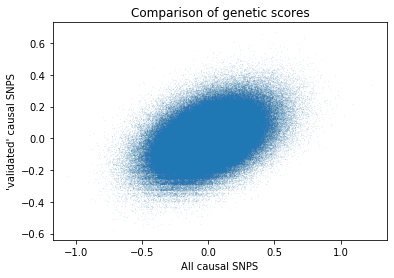

In [160]:
plt.scatter(score.score, score.score_val,s=.001)
plt.xlabel("All causal SNPS")
plt.ylabel("'validated' causal SNPS")
plt.title("Comparison of genetic scores")
pass

In [161]:
from glob import glob

## Score of Sysmex traits

In [162]:
sys_phenos = ["PLT#","MPV","PCT","PDW"]
score_dfs = []
for pheno in sys_phenos:
    dfs = []
    chrom_files = glob("%s/Genetic_score_Sysmex_traits/%s_causal_score_chr*.sscore" % (export_folder,pheno))
    for score_file in chrom_files:
        df = pd.read_csv(score_file,sep="\t")
        df = df.loc[df.IID.isin(EUR_IDs)]
        mean = (df["SCORE1_AVG"]*df["NMISS_ALLELE_CT"]).sum() / df["NMISS_ALLELE_CT"].sum()
        df["score"] = (df["SCORE1_AVG"] - mean)*df["NMISS_ALLELE_CT"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % chrom}))
    df = dfs[0]
    for d in dfs[1:]:
        df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
    df = df.set_index("IID")
    score_dfs.append(pd.DataFrame(df.sum(axis=1)).rename(columns={0:"score_%s" % pheno}))

In [163]:
for s in score_dfs:
    print(s.shape[0])

409016
409016
409016
409016


In [164]:
for i in range(len(score_dfs)):
    if score_dfs[i].shape[0] == score.shape[0]:
        print("add")
        score = pd.merge(score,score_dfs[i],left_index=True,right_index=True)

add
add
add
add


In [165]:
score.shape

(409016, 6)

In [166]:
score.std()

score         0.224991
score_val     0.132332
score_PLT#    0.523953
score_MPV     0.608917
score_PCT     0.467130
score_PDW     0.469907
dtype: float64

# Merge

In [79]:
# Scores were computed using only EUR people.
# Thus, the merge removes the non-europeans
ms = pd.merge(ukbb,score,left_on="ID",right_on="IID")
#ms = ms.loc[ms.KINSHIP < 1] # < 1 : no relatives, < 10 : less than 10 relatives
#ms = ms.loc[ms.TOBACCO != "Never smoke"]

In [80]:
ms.shape

(408920, 247)

## Remove related

In [81]:
glob('/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/')

['/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/']

In [83]:
rel = pd.read_csv("/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/ukb13745_rel_s488339.dat",sep=" ")
people_to_remove = rel.loc[rel.Kinship < 0.0612].ID2.unique().tolist()
ms = ms.loc[~ms.ID.isin(people_to_remove)]
print(ms.shape)

(384059, 247)


## Eventually remove non-europeans

In [84]:
ms.loc[ms.ID.isin(european_individuals.FID.tolist())].shape
ms = ms.loc[ms.ID.isin(european_individuals.FID.tolist())]

In [85]:
european_individuals.shape

(409016, 1)

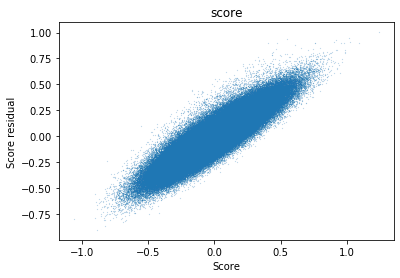

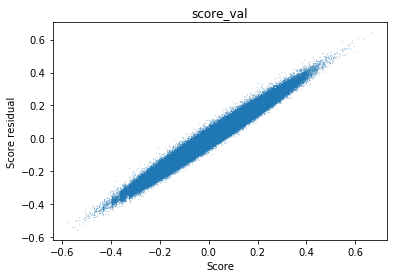

In [87]:
from sklearn.linear_model import LinearRegression

sys_cols = ["score_PLT#","score_PDW","score_PCT","score_MPV"]

for score_col in ["score","score_val"]:
    
    lm = LinearRegression().fit(ms[sys_cols],ms[score_col])
    score_pred = lm.predict(ms[sys_cols])

    ms["adjusted_%s" % score_col] = ms[score_col] - score_pred

    plt.figure()
    plt.scatter(ms[score_col], ms["adjusted_%s" % score_col],s=.01)
    plt.xlabel("Score")
    plt.ylabel("Score residual")
    plt.title(score_col)

In [88]:
print("Keeping %d cases" % ms.shape[0])
N = ms.shape[0]//3
print("Tails contain %d people each" % N)

Keeping 384059 cases
Tails contain 128019 people each


In [91]:
from scipy.stats import pearsonr, chisquare, binom_test
def compare_top_bottom(ms,has_col,age_col=None,score_col="score"):
    
    ms = ms.sort_values(by=score_col)
    top = ms.iloc[-N:].ID.tolist()
    bottom = ms.iloc[:N].ID.tolist()
    
    top_has = ms.loc[ms.ID.isin(top)][has_col]
    bot_has = ms.loc[ms.ID.isin(bottom)][has_col]
    score_has = ms.loc[ms[has_col],score_col]
    score_hasnt = ms.loc[~ms[has_col],score_col]
    n_top = top_has.sum()
    n_bot = bot_has.sum()
    
    binom_p = binom_test(bot_has.sum(),len(bottom),ms.loc[ms.ID.isin(top),has_col].mean())
    
    t_p = ttest_ind(score_hasnt,score_has)[1]
    return [n_top, n_bot, binom_p, t_p]

In [92]:
dic = {}
dfs = {}
for score_col in ["score","score_val","adjusted_score","adjusted_score_val"]:
    for ph in ["has_mi","haemo","arteriosclerosis","haemorroids","thrombosis","has_VT"]:
        dic[ph] = compare_top_bottom(ms,ph,score_col=score_col)
    dfs[score_col] = pd.DataFrame.from_dict(dic,orient="index",columns=["# in top","# in bottom","binom test","t-test"])

In [93]:
dfs["score"]

,# in top,# in bottom,binom test,t-test
has_mi,5331,4981,7.851492e-07,0.002880
haemo,509,569,8.761735e-03,0.154122
arteriosclerosis,9333,8966,7.442653e-05,0.012786
haemorroids,947,887,5.033199e-02,0.120829
thrombosis,1868,1796,9.558972e-02,0.038043
has_VT,2556,2423,7.642273e-03,0.073643


In [94]:
dfs["adjusted_score"]

,# in top,# in bottom,binom test,t-test
has_mi,5313,5088,0.001540,0.033459
haemo,549,524,0.294650,0.413411
arteriosclerosis,9320,9121,0.032295,0.150670
haemorroids,942,884,0.057850,0.052327
thrombosis,1869,1808,0.158591,0.175675
has_VT,2581,2458,0.014444,0.016513


In [95]:
dfs["score_val"]

,# in top,# in bottom,binom test,t-test
has_mi,5303,5033,0.000140,0.004096
haemo,529,547,0.432831,0.899225
arteriosclerosis,9225,9033,0.037967,0.085286
haemorroids,945,916,0.352073,0.188122
thrombosis,1835,1783,0.225899,0.066684
has_VT,2466,2514,0.329029,0.907926


In [96]:
dfs["adjusted_score_val"]

,# in top,# in bottom,binom test,t-test
has_mi,5271,5044,0.001340,0.011792
haemo,543,532,0.651602,0.334137
arteriosclerosis,9179,9079,0.281073,0.186502
haemorroids,952,910,0.176959,0.173401
thrombosis,1846,1800,0.286087,0.112546
has_VT,2502,2512,0.839988,0.843689


## P-values by likelihoods comparison

In [100]:
from sklearn.linear_model import LogisticRegression

In [113]:
X_sys = ms[sys_cols].values
X_all = ms[sys_cols+["adjusted_score_val"]].values
X_sys -= X_sys.mean(axis=0)
X_sys /= X_sys.std(axis=0)
X_all -= X_all.mean(axis=0)
X_all /= X_all.std(axis=0)


In [114]:
def likelihood(lr,X,y):
    lp = lr.predict_log_proba(X)
    return np.sum(lp[y == 0,0]) + np.sum(lp[y == 1,1])

In [126]:
y = ms.has_mi*1
lr_sys = LogisticRegression(solver="lbfgs")
lr_sys.fit(X_sys,y)
lr_all = LogisticRegression(solver="lbfgs")
lr_all.fit(X_all,y)
pass

In [127]:
p = np.stack([np.mean(y)*np.ones(y.shape[0]),(1-np.mean(y))*np.ones(y.shape[0])]).T
null_log_proba = y.sum()*np.log(y.mean()) + (y.shape[0]-y.sum())*np.log(1-y.mean())

In [128]:
null_log_proba

-64911.89606743929

In [129]:
delta_D = 2*(likelihood(lr_sys,X_sys,y) - likelihood(lr_all,X_all,y))
print(delta_D)

-6.339434704073938


In [130]:
from scipy.stats import chi2
chi2.sf(-delta_D,1)

0.011808250837192485

When to start 
Include PCT, PLT etc as covariates, worry about the date
MI : use those which happened after the PLT measurement
Include Sysmex genetic scores from paper (link from Will)
Mendelian Randomization : correlation between genetic score of risk factor and phenotype

# Survival analysis

In [131]:
from lifelines import KaplanMeierFitter
from datetime import datetime

In [132]:
X = ms.copy()
X = X.loc[~X.BIRTH.isnull()]
X["AGE"] = datetime.now() - X["BIRTH"]

In [133]:
# Should these be removed from the other analysis ?
X["DEATH_AGE"].fillna(1000,inplace=True)
X["MI_AGE"].fillna(1000,inplace=True)
X["HIGH_BP_AGE"].fillna(1000,inplace=True)
X["VT_AGE"].fillna(1000,inplace=True)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.93 <0.005      8.47

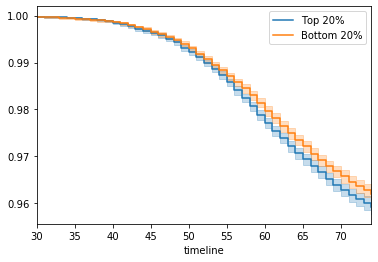

In [139]:
score_col = "adjusted_score"

pheno = "has_mi"
age_col = "MI_AGE"

#pheno = "has_hbp"
#age_col = "HIGH_BP_AGE"

#pheno = "has_stroke"
#age_col = "STROKE_AGE"

#pheno = "has_VT"
#age_col = "VT_AGE"

X["min_T"] = X["AGE"]
X.loc[X["min_T"] > X["DEATH_AGE"],"min_T"] = X.loc[X["min_T"] > X["DEATH_AGE"],"DEATH_AGE"]
X.loc[X["min_T"] > X[age_col],"min_T"] = X.loc[X["min_T"] > X[age_col],age_col]

N = ms.shape[0] // 5
X = X.sort_values(by=score_col)
top = X.iloc[-N:].ID.tolist()
bottom = X.iloc[:N].ID.tolist()
km = KaplanMeierFitter()
km.fit(X.loc[X.ID.isin(top)].min_T,event_observed=1*X.loc[X.ID.isin(top),pheno],label='Top 20%',timeline=range(30, 75, 1))
ax = km.plot()
km.fit(X.loc[X.ID.isin(bottom)].min_T,event_observed=1*X.loc[X.ID.isin(bottom),pheno],label="Bottom 20%",timeline=range(30, 75, 1))
km.plot(ax=ax)

results = logrank_test(X.loc[X.ID.isin(top)].min_T, 
                       X.loc[X.ID.isin(bottom)].min_T, 
                       1*X.loc[X.ID.isin(top),pheno], 
                       1*X.loc[X.ID.isin(bottom),pheno], alpha=.99)

results.print_summary()